# Plotting the correlograms and Lomb-Scargle periodograms for the stars from Mathur et al. ([2014](https://www.mendeley.com/catalogue/investigating-magnetic-activity-f-stars-kepler-mission/)) and comparing observable peaks to the period values from the paper

Importing non-standard packages and modules:

[kplr](https://github.com/dfm/kplr), and [autocorr](https://github.com/dfm/emcee/blob/master/src/emcee/autocorr.py) module from [emcee](https://github.com/dfm/emcee) developed by [Daniel Foreman-Mackey](https://github.com/dfm) and other contributors;<br>
[matplotlib](https://github.com/matplotlib/matplotlib) developed by [Michael Droettboom](https://github.com/mdboom),  [Thomas Caswell](https://github.com/tacaswell) and other contributors;<br>
[autograd](https://github.com/HIPS/autograd) developed by [Dougal Maclaurin](https://dougalmaclaurin.com), [David Duvenaud](https://www.cs.toronto.edu/~duvenaud/), [Matt Johnson](http://people.csail.mit.edu/mattjj/), [Jamie Townsend](https://github.com/j-towns) and other contributors;<br>
[timeseries](https://github.com/astropy/astropy/tree/master/astropy/timeseries) module from [astropy](https://github.com/astropy/astropy) developed by contributors.

In [1]:
import kplr # Tools for working with Kepler data
from emcee import autocorr as ac # Autocorrelation Functions

from matplotlib import rcParams as rcP, pyplot as plt  # Plots
from autograd import numpy as np # Derivatives of numpy code
from astropy.timeseries import LombScargle # Computing of the Lomb-Scargle Periodogram

Setting plots parameters:

In [2]:
# A magic command to get inline plots within a Python Notebook
%matplotlib inline

# A magic command to enable 2x plots
%config IPython.matplotlib.backend = "retina"

# Setting DPIs of figures
rcP["savefig.dpi"] = 300
rcP["figure.dpi"]  = 300

# Setting other plots settings

rcP["font.size"] = 16
rcP["legend.fontsize"] = 12
rcP["font.family"] = "sans"
rcP["font.sans-serif"] = ["Dejavu Sans"]

Defining a function to load data from the [Kepler Input Catalog](https://archive.stsci.edu/kepler/kic.html):

In [3]:
def get_data(kic_id):
    """
    A function to get short cadence light curves data from a star
    with specified ID from the Kepler Input Catalog 
    
    Args:
        kic_id: The id of a star in the Kepler Input Catalog.
         
    Returns:
        array: Time values of the time series;
        array: Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values.
        
    """

    # Attaching the kplr API
    client = kplr.API()

    # Getting the star data
    star = client.star(kic_id)

    # Time values
    t = []
    
    # Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
    f = []
    
    # Getting short cadence light curves
    for lc in star.get_light_curves(short_cadence=False):
        
        # Reading data from a light curve
        data = lc.read()
        
        # Getting time values from the data
        t0 = data["TIME"]
        
        # Getting PDCSAP flux values from the data
        f0 = data["PDCSAP_FLUX"]
        
        # Creating a mask for only qualitative data points
        mask = (data["SAP_QUALITY"] == 0) & np.isfinite(t0) & np.isfinite(f0)
    
        # Appending the qualitative time data to the existing list
        t.append(t0[mask])
        
        # Computing the median of the flux data
        mu = np.median(f0[mask])
        
        # Scaling the qualitative flux data and appending these to the existing list
        f.append( ( f0[mask] / mu - 1.0 ) * 1e3 )
        
    # Concatenating the arrays within the lists
    
    t = np.concatenate(t)
    f = np.concatenate(f)
    
    # Getting contiguous arrays
    
    t = np.ascontiguousarray(t, dtype = float)
    f = np.ascontiguousarray(f, dtype = float)
    
    # Returning arrays
    
    return t, f

Defining a function to calculate the autocorrelation function and to plot the correlogram from the [Kepler](https://archive.stsci.edu/kepler/kic.html) data:

In [4]:
def get_cor(t, f, kic_id, check_value):
    """
    A function to calculate the autocorrelation function and
    to plot the correlogram of short cadence light 
    curves data; to add the line of the period value
    taken from Mathur et al. (2014)
    
    Args:
        t: An array of time values;
        f: An array of flux values;
        kic_id: The id of a star in the Kepler Input Catalog;
        check_value: The period value taken for a star referred in Mathur et al. (2014)
    
    """
    
    # Calculating the median of the first order differences of the time array 
    delta_t = np.median(np.diff(t))
    
    # Interpolating values within the time array with delta_t spacing
    f_interp = np.interp(np.arange(t.min(), t.max(), delta_t), t, f)
    
    # Calculating unnormalized autocorrelation function
    corr = ac.function_1d(f_interp) * np.var(f_interp)

    # Defining a lag array
    tau = np.arange(len(corr)) * delta_t
    
    # Plotting data
    plt.plot(tau, corr)

    # Adding a line for the specified checking period value 
    
    plt.axvline(check_value, color="k", ls="dashed", alpha=0.5, label=str(check_value) + " days")

    # Adding a legend
    plt.legend(loc="upper right")

    # Limitting the plot
    plt.xlim(0, 20)
    
    # Setting title
    plt.title("The correlogram of KIC " + str(kic_id))
    
    # Setting labels
    plt.ylabel(r"$k(\tau)$")
    plt.xlabel(r"$\tau$")

    # Saving the figure
    plt.savefig("figures/KIC_" + str(kic_id) + "_C.png", bbox_inches="tight")

    # Showing the plot in a cell
    plt.show()

Defining a function to calculate and plot the Lomb-Scargle periodogram from the [Kepler](https://archive.stsci.edu/kepler/kic.html) data:

In [5]:
def get_per(t, f, kic_id, check_value):

    # Creating a set of evenly spaced frequencies 
    freq = np.linspace(1e-1, 1.0, 5000)
    
    # Getting the PSD-normalized Lomb-Scargle power spectrum of the data using the fast method (O[N log N])
    power = LombScargle(t, f).power(freq, method="fast", normalization="psd")
    
    # Determining the maximum peak
    period = 1.0 / freq[np.argmax(power)]
    
    # Scaling the output
    power /= len(t)
    
    # Plotting data
    plt.plot(1.0 / freq, power)
    
    # Marking the true period value
    plt.axvline(check_value, color="k", ls="dashed", alpha=0.5, label=str(check_value) + " days")
    
    # Adding a legend
    plt.legend(loc="upper right")
    
    # Setting axis limits
    plt.xlim(period - 1, period + 1)
    plt.ylim(0, 0.0007)
    
    # Setting labels
    plt.xlabel("Period, days")
    plt.ylabel("Power")
    plt.title("Lomb-Scargle periodogram")
    
    # Saving the figure
    plt.savefig("figures/KIC_" + str(kic_id) + "_P.png", bbox_inches="tight")

    # Showing the plot in a cell
    plt.show()

[KIC 1430163](https://archive.stsci.edu/kepler/data_search/search.php?target=1430163&action=Search&outputformat=HTML_Table), 3.88 $\pm$ 0.58 days:

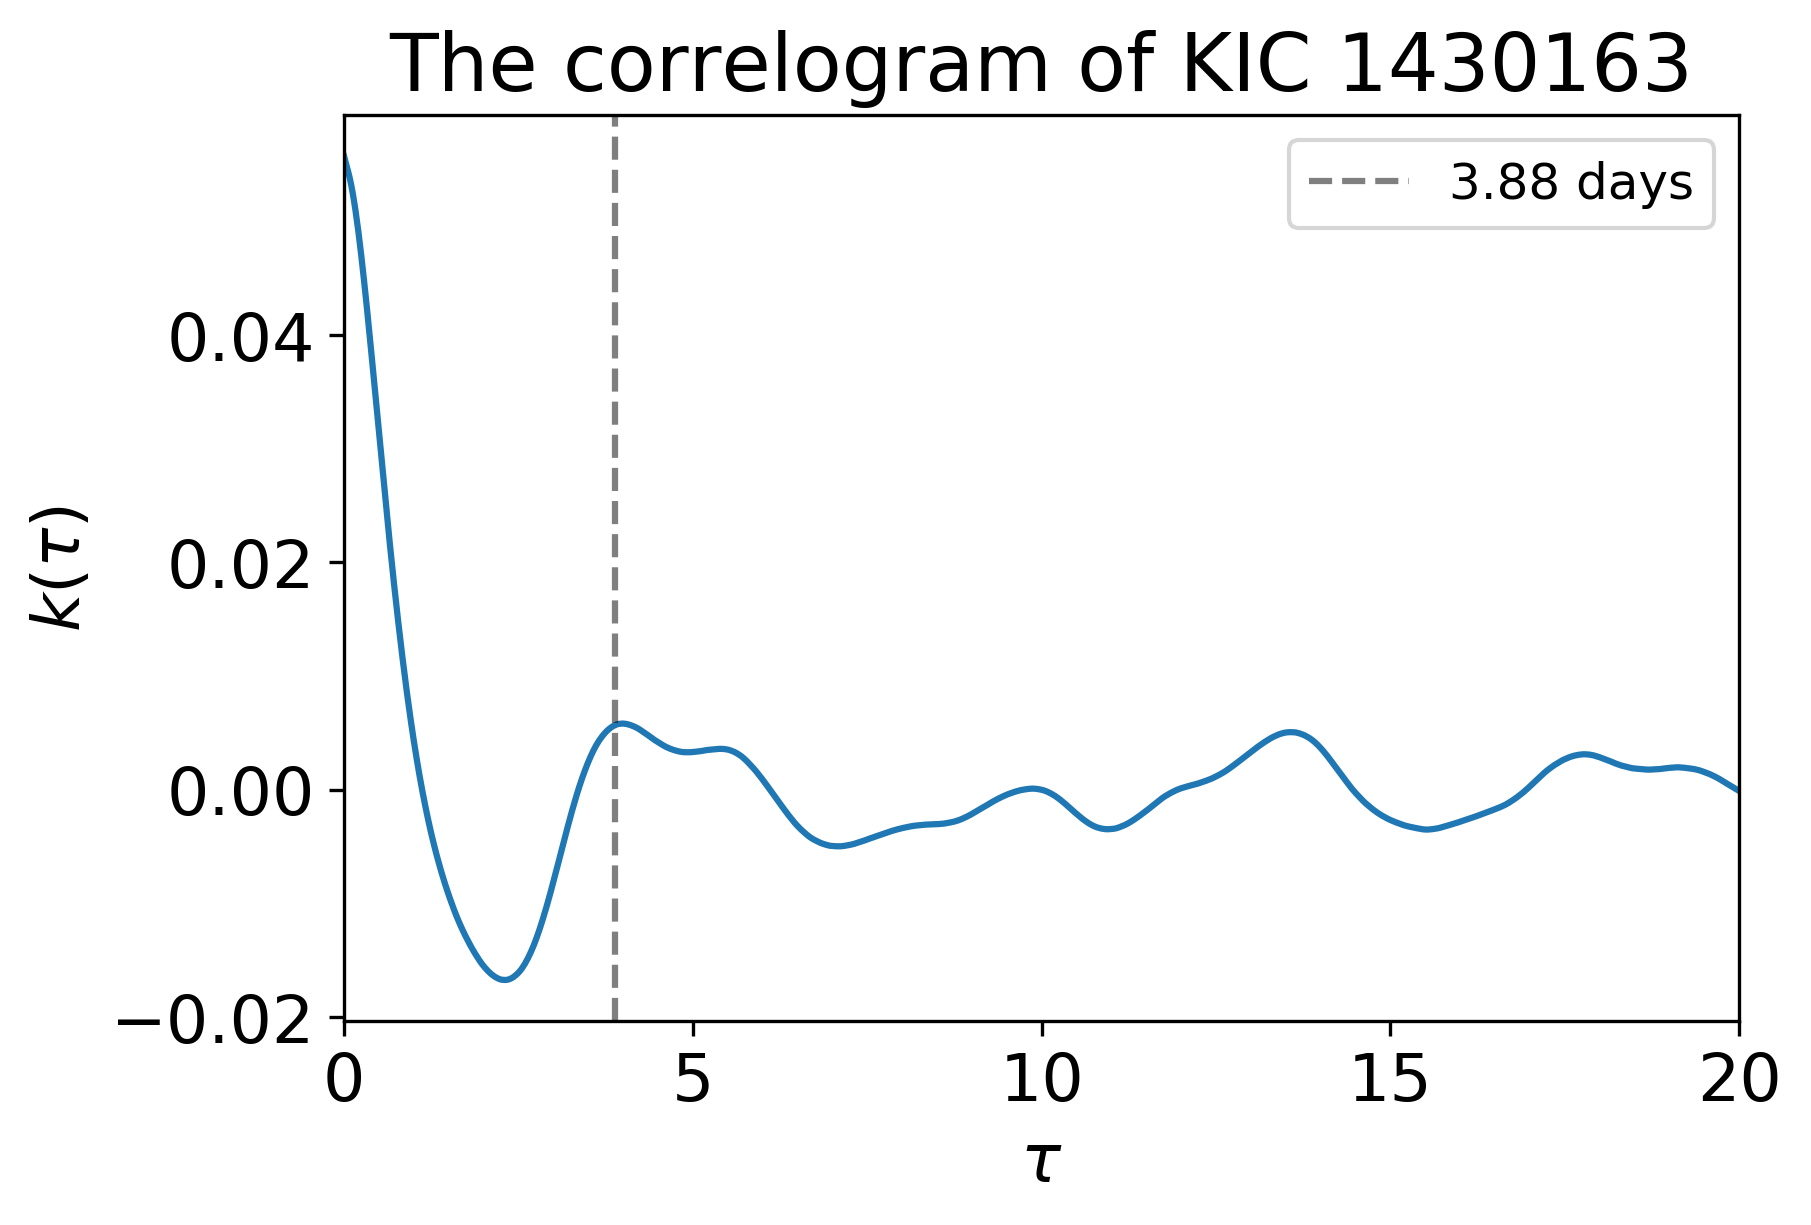

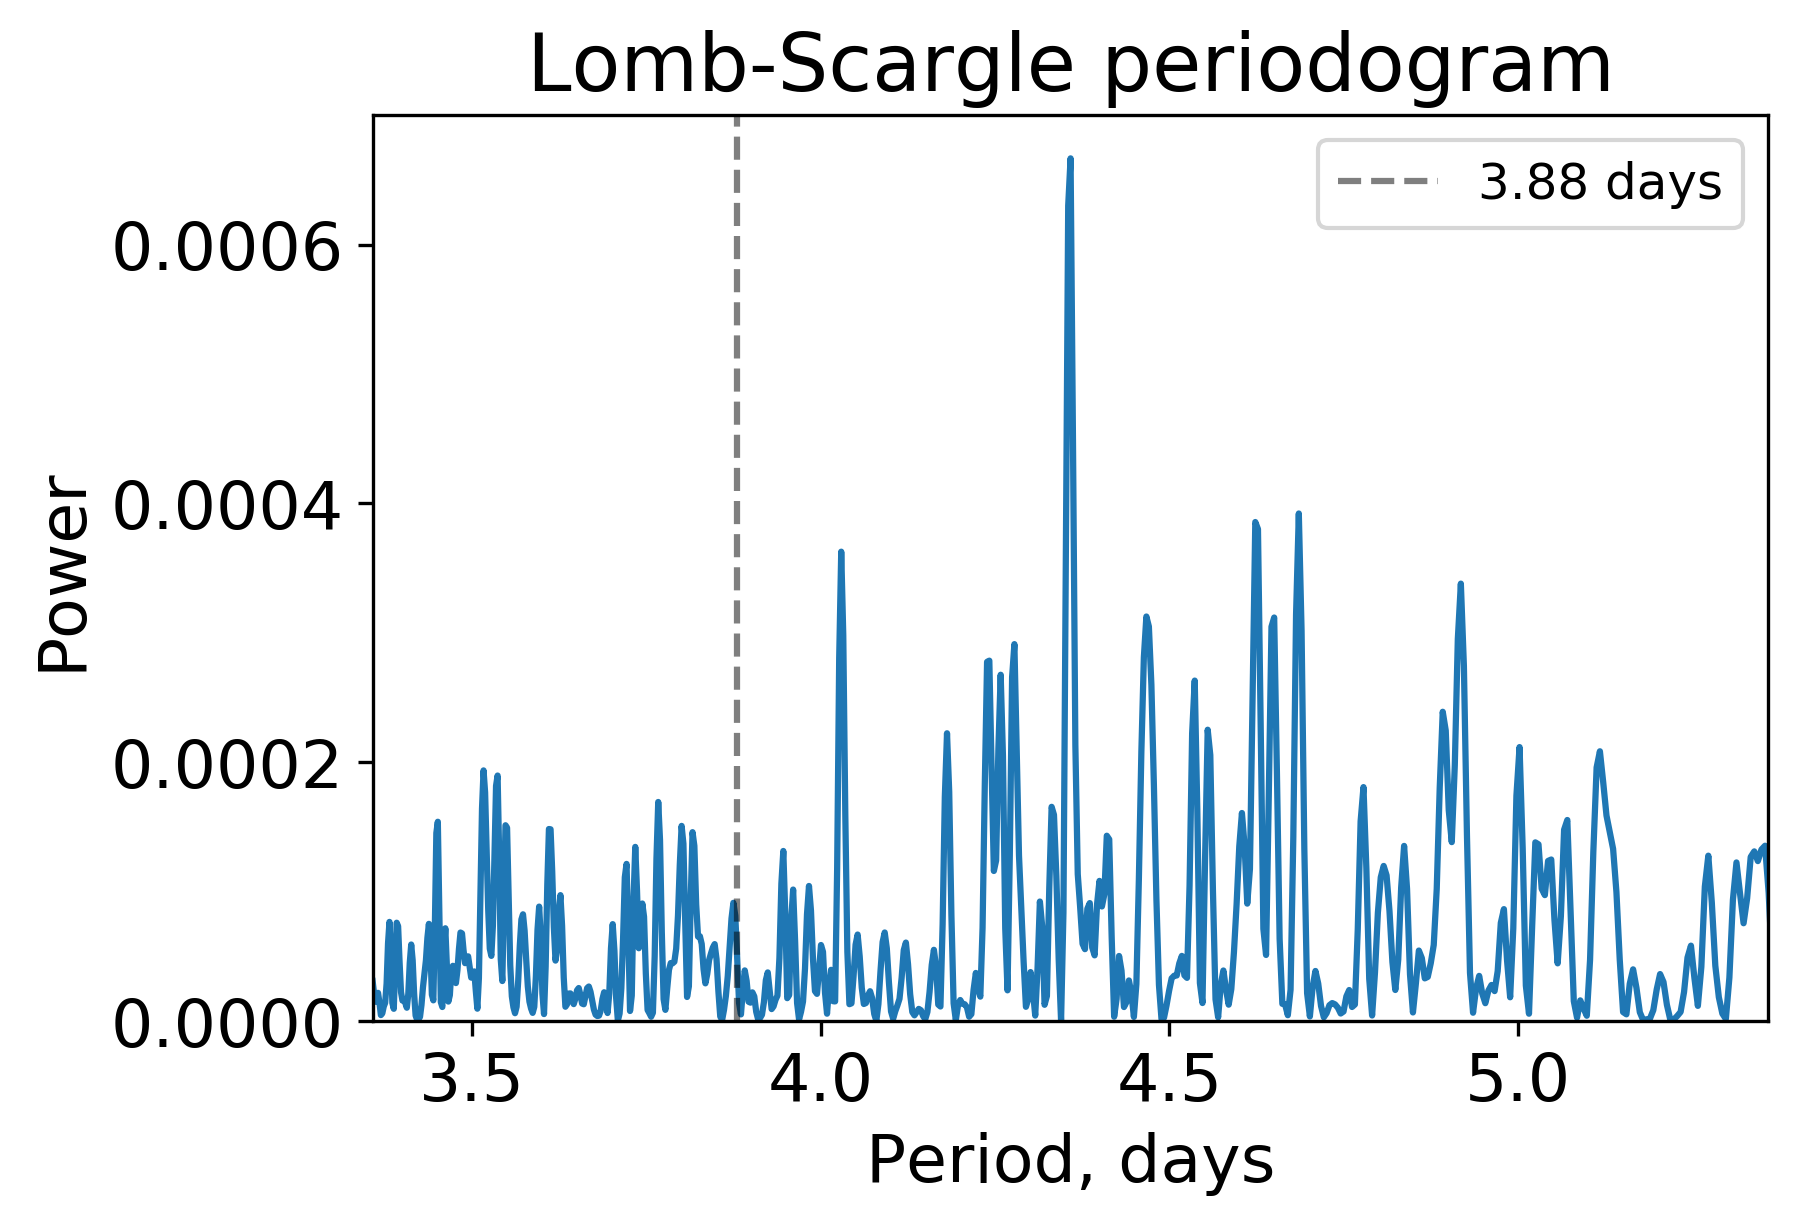

In [6]:
# Specifying KIC ID of a star
KIC = 1430163

# Specifying a check value for the period of the star
period_check = 3.88

# Getting data arrays
ta, fa = get_data(KIC)

# Computing and plotting the correlogram
get_cor(ta, fa, KIC, period_check)

# Computing and plotting the periodogram
get_per(ta, fa, KIC, period_check)

[KIC 1435467](https://archive.stsci.edu/kepler/data_search/search.php?target=1435467&action=Search&outputformat=HTML_Table), 6.53 $\pm$ 0.64 days:

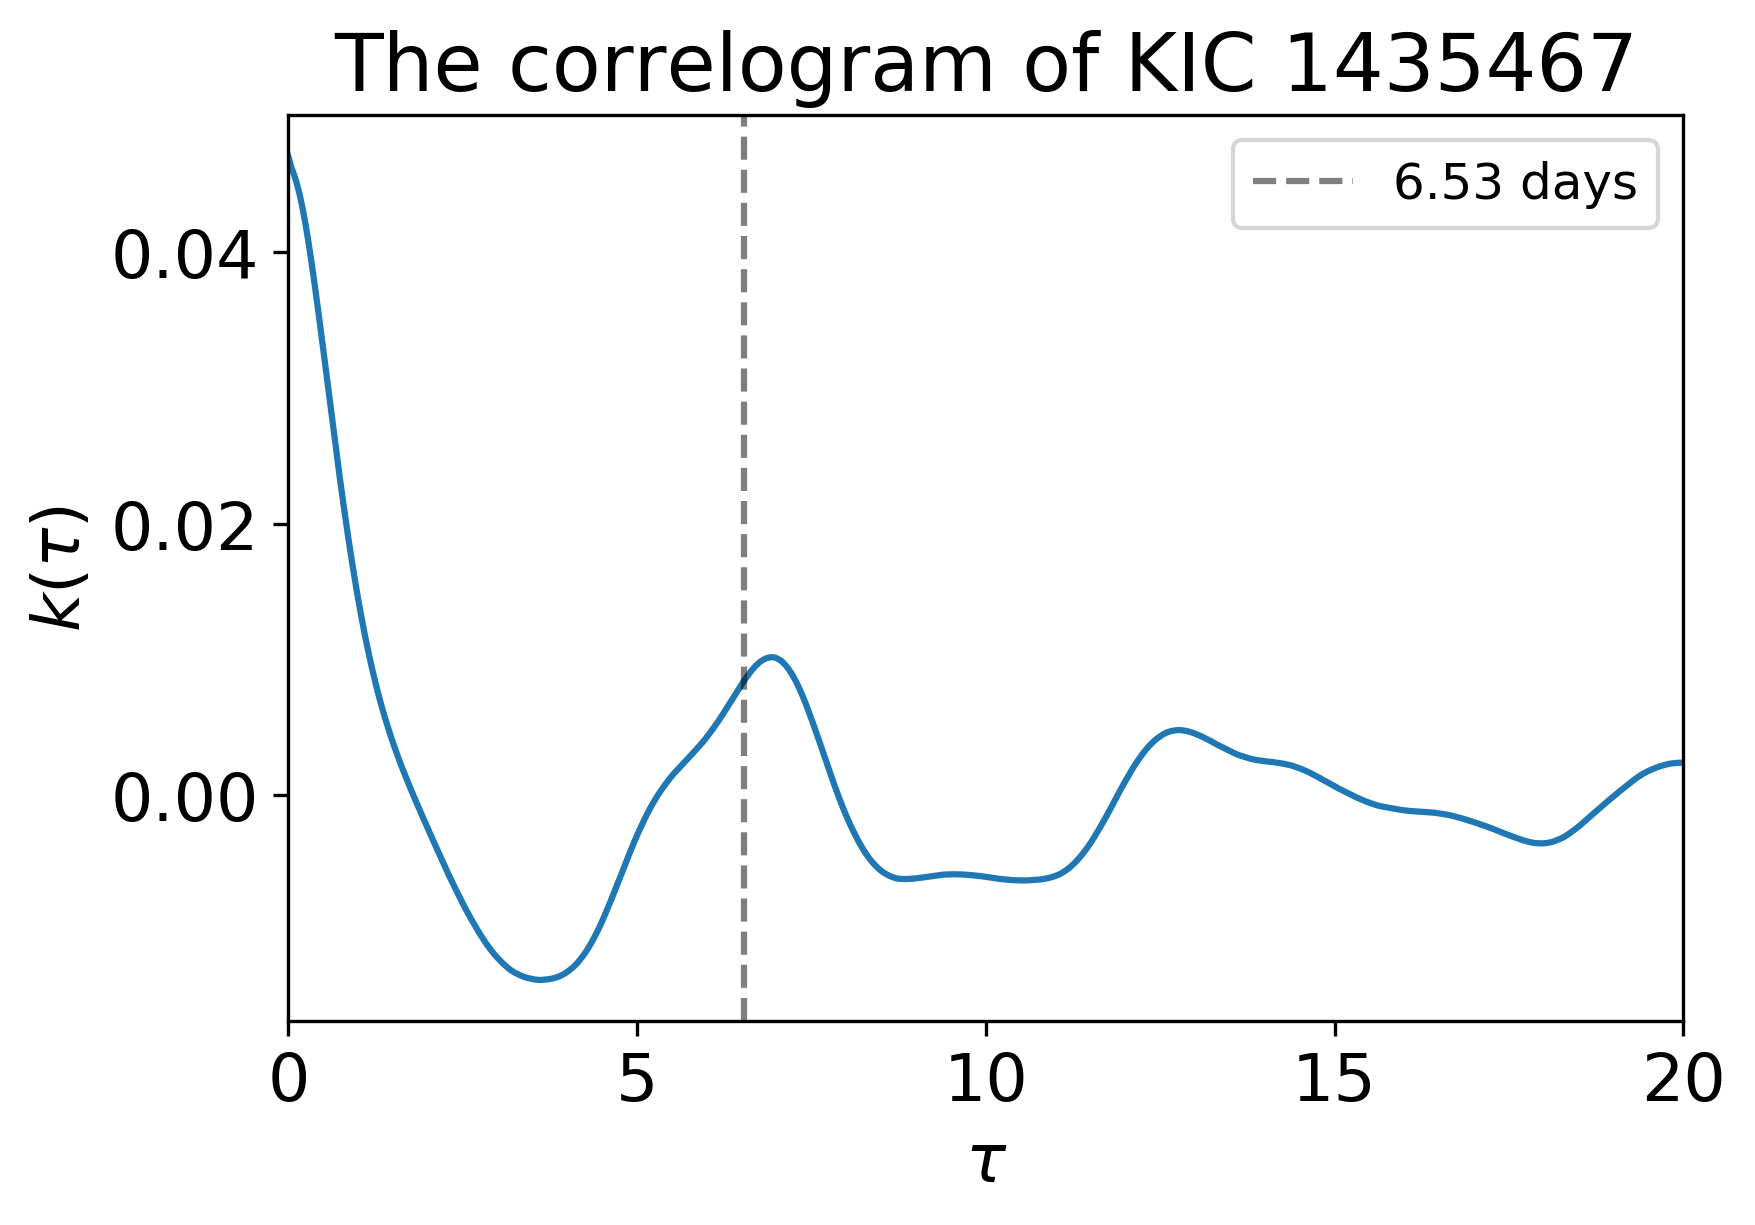

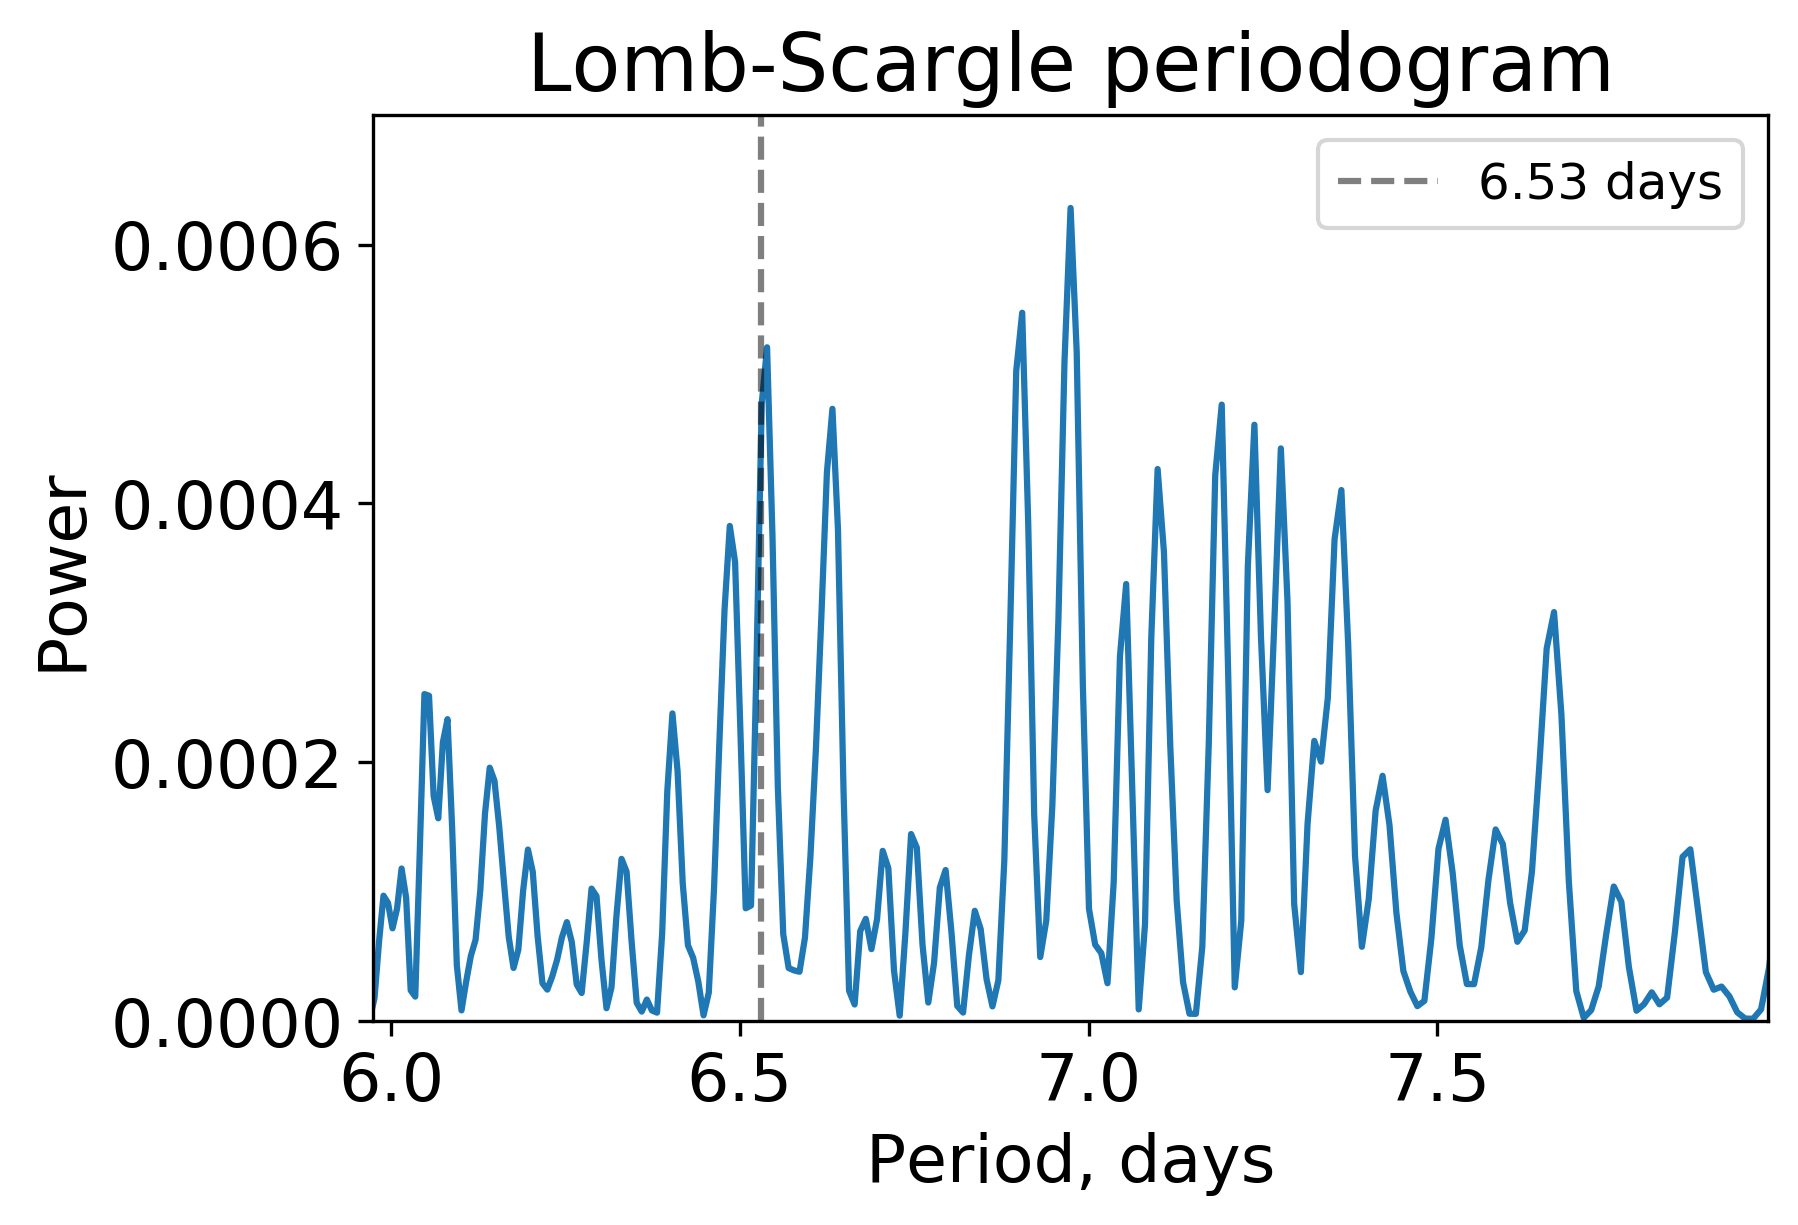

In [7]:
# Specifying KIC ID of a star
KIC = 1435467

# Specifying a check value for the period of the star
period_check = 6.53

# Getting data arrays
ta, fa = get_data(KIC)

# Computing and plotting the correlogram
get_cor(ta, fa, KIC, period_check)

# Computing and plotting the periodogram
get_per(ta, fa, KIC, period_check)